epoch:  19 	 loss: 32.197 	 return: 93.500 	 ep_len: 93.500
epoch:   0 	 loss: 7.048 	 return: 16.142 	 ep_len: 16.142
epoch:   1 	 loss: 8.668 	 return: 18.838 	 ep_len: 18.838
epoch:   2 	 loss: 8.826 	 return: 19.620 	 ep_len: 19.620
epoch:   3 	 loss: 12.364 	 return: 26.193 	 ep_len: 26.193
epoch:   4 	 loss: 12.720 	 return: 27.228 	 ep_len: 27.228
epoch:   5 	 loss: 14.245 	 return: 30.127 	 ep_len: 30.127
epoch:   6 	 loss: 15.264 	 return: 31.904 	 ep_len: 31.904
epoch:   7 	 loss: 15.893 	 return: 35.489 	 ep_len: 35.489
epoch:   8 	 loss: 17.564 	 return: 40.080 	 ep_len: 40.080
epoch:   9 	 loss: 19.334 	 return: 43.224 	 ep_len: 43.224


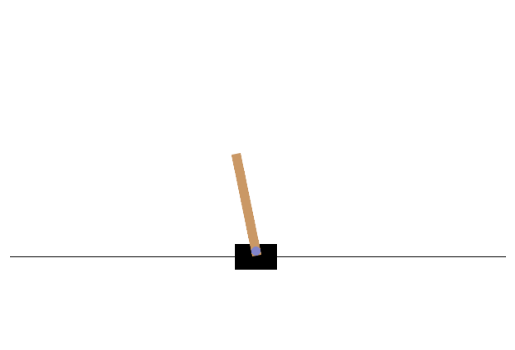

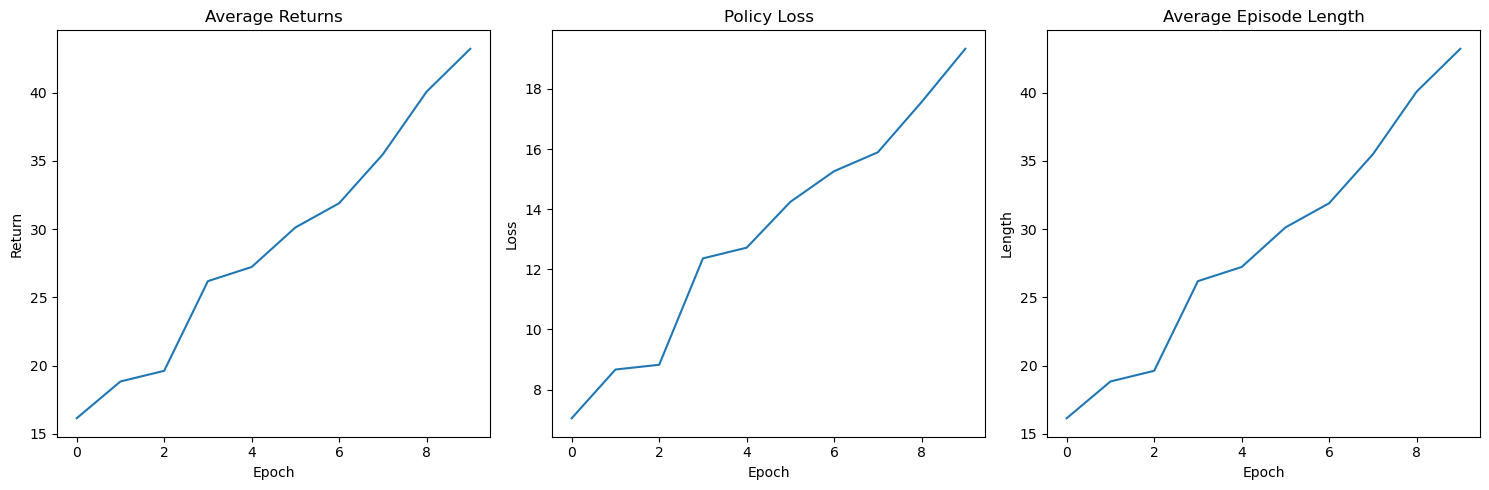

: 

In [6]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

# Set up device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def reward_to_go(rews):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return rtgs

def train(env_name='CartPole-v0', hidden_sizes=[32], lr=1e-2, epochs=50, batch_size=5000, render=False):
    # make environment, check spaces, get obs / act dims
    env = gym.make(env_name, render_mode="rgb_array")
    assert isinstance(env.observation_space, Box), \
        "This example only works for envs with continuous state spaces."
    assert isinstance(env.action_space, Discrete), \
        "This example only works for envs with discrete action spaces."

    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n

    # make core of policy network
    logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts]).to(device)

    # make function to compute action distribution
    def get_policy(obs):
        logits = logits_net(obs)
        return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
        return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
        logp = get_policy(obs).log_prob(act)
        return -(logp * weights).mean()

    # make optimizer
    optimizer = Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for reward-to-go weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs, _ = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False

        # collect experience by acting in the environment with current policy
        while True:
            # rendering
            if (not finished_rendering_this_epoch) and render:
                frame = env.render()
                plt.imshow(frame)
                plt.axis('off')
                display(plt.gcf())
                clear_output(wait=True)
                time.sleep(0.01)  # Add a small delay for visualization

            # save obs
            batch_obs.append(obs.copy())

            # act in the environment
            act = get_action(torch.as_tensor(obs, dtype=torch.float32).to(device))
            obs, rew, terminated, truncated, _ = env.step(act)
            done = terminated or truncated

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a_t|s_t) is reward-to-go from t
                batch_weights += list(reward_to_go(ep_rews))

                # reset episode-specific variables
                obs, _ = env.reset()
                done, ep_rews = False, []

                # won't render again this epoch
                finished_rendering_this_epoch = True

                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(
            obs=torch.as_tensor(batch_obs, dtype=torch.float32).to(device),
            act=torch.as_tensor(batch_acts, dtype=torch.int32).to(device),
            weights=torch.as_tensor(batch_weights, dtype=torch.float32).to(device)
        )
        batch_loss.backward()
        optimizer.step()
        return batch_loss, batch_rets, batch_lens

    # training loop
    for i in range(epochs):
        batch_loss, batch_rets, batch_lens = train_one_epoch()
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

# Run training with visualization
train(env_name='CartPole-v0', hidden_sizes=[32], lr=1e-2, epochs=20, batch_size=500, render=True)

# Run training and collect metrics
returns = []
losses = []
ep_lens = []

def train_with_metrics(env_name='CartPole-v0', hidden_sizes=[32], lr=1e-2, epochs=10, batch_size=5000):
    # make environment, check spaces, get obs / act dims
    env = gym.make(env_name, render_mode="rgb_array")
    assert isinstance(env.observation_space, Box), \
        "This example only works for envs with continuous state spaces."
    assert isinstance(env.action_space, Discrete), \
        "This example only works for envs with discrete action spaces."

    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n

    # make core of policy network
    logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts]).to(device)

    # make function to compute action distribution
    def get_policy(obs):
        logits = logits_net(obs)
        return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
        return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
        logp = get_policy(obs).log_prob(act)
        return -(logp * weights).mean()

    # make optimizer
    optimizer = Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for reward-to-go weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs, _ = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # collect experience by acting in the environment with current policy
        while True:
            # save obs
            batch_obs.append(obs.copy())

            # act in the environment
            act = get_action(torch.as_tensor(obs, dtype=torch.float32).to(device))
            obs, rew, terminated, truncated, _ = env.step(act)
            done = terminated or truncated

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a_t|s_t) is reward-to-go from t
                batch_weights += list(reward_to_go(ep_rews))

                # reset episode-specific variables
                obs, _ = env.reset()
                done, ep_rews = False, []

                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(
            obs=torch.as_tensor(batch_obs, dtype=torch.float32).to(device),
            act=torch.as_tensor(batch_acts, dtype=torch.int32).to(device),
            weights=torch.as_tensor(batch_weights, dtype=torch.float32).to(device)
        )
        batch_loss.backward()
        optimizer.step()
        return batch_loss, batch_rets, batch_lens

    # training loop
    for i in range(epochs):
        batch_loss, batch_rets, batch_lens = train_one_epoch()
        returns.append(np.mean(batch_rets))
        losses.append(batch_loss.item())
        ep_lens.append(np.mean(batch_lens))
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))
    
    return returns, losses, ep_lens

# Run training and collect metrics
returns, losses, ep_lens = train_with_metrics()

# Plot the results
plt.figure(figsize=(15, 5))

# Plot returns
plt.subplot(131)
plt.plot(returns)
plt.title('Average Returns')
plt.xlabel('Epoch')
plt.ylabel('Return')

# Plot losses
plt.subplot(132)
plt.plot(losses)
plt.title('Policy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot episode lengths
plt.subplot(133)
plt.plot(ep_lens)
plt.title('Average Episode Length')
plt.xlabel('Epoch')
plt.ylabel('Length')

plt.tight_layout()
plt.show()